In [827]:
# need file ../../../analysis.py
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent.parent))

import analysis


In [828]:
import pandas as pd

PWD = Path.cwd()

In [829]:
df = pd.read_csv(
    f'{PWD}/LLM+Answer+Evaluation_25+September+2024_16.30.tsv',
    sep='\t',
    encoding='utf-16',
)

questions = pd.read_json('../surveys/survey.jsonl', lines=True)


datasets = questions['dataset'].unique()[:-1]
models = questions['model'].unique()
dataset_model_combinations = [(d, m) for d in datasets for m in models]

POINT_SCALE = 5


/tmp/ipykernel_6727/2398572448.py:1: DtypeWarning: Columns (4,5,6,9,10,11,12,13,14,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,43,44,45,46,47,48,49,50,51,58,59,60,64,65,66,67,68,69,70,71,72,76,77,78,91,92,93,94,95,96,100,101,102,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,265,266,267,268,269,270,271,272,273,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,

In [830]:
datasets, models

(array(['Franklin', 'GSM8k', 'HotpotQA', 'StrategyQA'], dtype=object),
 array(['google/gemma-2-9b-it', 'meta-llama/Meta-Llama-3.1-8B-Instruct',
        'microsoft/Phi-3.5-mini-instruct', 'openai/gpt-4o-mini'],
       dtype=object))

In [831]:
questions.head()

,uuid,is_attention_check,dataset,model,question,parsed_response,html
0,1c9b5176-426a-4204-846b-a3f8b500f14f,False,Franklin,google/gemma-2-9b-it,Which country will have the lower energy consu...,"I do not have access to real-time information,...",<p><em>Which country will have the lower energ...
1,a58302d2-d144-4f4f-8f3b-b56220312d6b,False,Franklin,google/gemma-2-9b-it,Which country in Northern Europe had the highe...,Here's how to find the answer:\n\n* **Identify...,<p><em>Which country in Northern Europe had th...
2,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee,False,Franklin,google/gemma-2-9b-it,Which country in Eastern Asia had the highest ...,Here's how to find the answer:\n\n* **Identify...,<p><em>Which country in Eastern Asia had the h...
3,f7f44e54-e848-4e48-a6d7-e1fa552754d4,False,Franklin,google/gemma-2-9b-it,For the country in Micronesia that had the low...,I cannot answer this question. \n\nHere's why:...,<p><em>For the country in Micronesia that had ...
4,da574fdf-3fc9-4191-a373-b015b3584e8b,False,Franklin,google/gemma-2-9b-it,Which country will have the higher life expect...,Here's how to approach this question:\n\n* **L...,<p><em>Which country will have the higher life...


In [832]:
# set column name to item in row 0
df.columns = df.iloc[0]
# drop the first row
df = df.drop(0)
# set index to 'PROLIFIC_PID'
df = df.set_index('PROLIFIC_PID')

In [833]:
# get durations and remove outliers
durations = df['Duration (in seconds)'].astype(float).map(lambda x: x / 60)
# print some stats about duration
print(durations.describe())

count    267.000000
mean      17.947253
std        9.836949
min        0.116667
25%       11.658333
50%       15.933333
75%       21.741667
max       57.766667
Name: Duration (in seconds), dtype: float64


In [834]:
# get durations which are more than 3 standard deviations lower than the mean
outliers_time = durations.mean() - 3 * durations.std()
print(f'Minimum permissible time: {outliers_time} minutes')
outliers = durations[durations < outliers_time]
print(outliers)
# remove outliers
df = df[~df.index.isin(outliers.index)]

Minimum permissible time: -11.563593105497404 minutes
Series([], Name: Duration (in seconds), dtype: float64)


In [835]:
# find the uuid in the string using regex to match a 36 character string
df.columns = df.columns.str.extract(r'([a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}_[1-4])')[0]
# only return columns where there is a match
df = df[df.columns.dropna()]
# drop columns with all NaN values
df = df.dropna(axis=1, how='all')

In [836]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 60cd16e63d3924958e8d3d43 to 629aaa38fdfc8168501b930e
Columns: 3080 entries, 1c9b5176-426a-4204-846b-a3f8b500f14f_1 to 6f401f5d-264c-4bd3-98a2-e3e0826eef74_3
dtypes: object(3080)
memory usage: 6.3+ MB


Attention checks

In [837]:
# get the attention check uuids
attention_check_agree_uuid = 'd67998d7-8f14-4f50-823b-cb63027f21d9'
attention_check_disagree_uuid = 'e45763f5-53c4-4006-b2f8-edfbfd7e289e'
# get the attention check columns
attention_check_somewhat_agree = [f'{attention_check_agree_uuid}_{i}' for i in range(1, 5)]
attention_check_strongly_disagree = [f'{attention_check_disagree_uuid}_{i}' for i in range(1, 5)]
# make a dataframe with the attention check columns
attention_check_df = df[attention_check_somewhat_agree + attention_check_strongly_disagree]
# drop these columns from the dataframe
df = df.drop(attention_check_df.columns, axis=1)
# filter out the attention check columns
attention_check_df = attention_check_df.filter(regex='_4$', axis=1)
# rename the columns
attention_check_df = attention_check_df.rename(
    columns={
        'd67998d7-8f14-4f50-823b-cb63027f21d9_4': 'Somewhat agree',
        'e45763f5-53c4-4006-b2f8-edfbfd7e289e_4': 'Strongly disagree',
    }
)
# confirm columns contain the correct values
attention_check_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 60cd16e63d3924958e8d3d43 to 629aaa38fdfc8168501b930e
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Somewhat agree     260 non-null    object
 1   Strongly disagree  260 non-null    object
dtypes: object(2)
memory usage: 14.4+ KB


In [838]:
# get rows where cell does not match column name for both columns
attention_check_df = attention_check_df[
    (attention_check_df['Somewhat agree'] != 'Somewhat agree')
    | (attention_check_df['Strongly disagree'] != 'Strongly disagree')
]
attention_check_df.loc['602a2911a73ba046955f6c58']

0
Somewhat agree       Strongly agree
Strongly disagree    Strongly agree
Name: 602a2911a73ba046955f6c58, dtype: object

In [839]:
print(f'Failed attention checks: {len(attention_check_df)}/{len(df)} ({len(attention_check_df) / len(df) * 100:.2f}%)')
# remove rows where attention check failed
df = df[~df.index.isin(attention_check_df.index)]

Failed attention checks: 30/267 (11.24%)


In [840]:
# convert text to integer
point_scale = 5
df = df.map(lambda x: analysis.t2i(x, point_scale))

In [841]:
# get rows where all non-NaN values are the same
rows = df.apply(lambda x: len(set(x.dropna())) == 1, axis=1)
# print rows where value is true and not false
rows = rows[rows == True]
print(f'Rows with same values: {len(rows)} ({len(rows) / len(df) * 100:.2f}%)')
# drop these rows from the dataframe
df = df.drop(rows.index)

Rows with same values: 0 (0.00%)


In [842]:
"""
Split main dataframe into 3 dataframes for each variation of the question.
Split also by dataset and model.
"""
# get uuids in survey
uuids_in_survey = {i.split('_')[0] for i in df.columns}
# get questions where questions['uuid'] is in uuids_in_survey
questions = questions[questions['uuid'].isin(uuids_in_survey)]
# many-to-one mapping between ('model', 'dataset') and 'uuid'. get uuids for each ('model', 'dataset') pair
grouped_uuids = questions.groupby(['dataset', 'model'])['uuid'].apply(list).to_dict()
# each uuid contains 3 variations with suffixes _1, _2, _3. create separate dataframes for each variation
Q1, Q2, Q3 = {}, {}, {}
for (dataset, model), uuids in grouped_uuids.items():
    Q1[(dataset, model)] = df[[f'{uuid}_1' for uuid in uuids]]
    Q2[(dataset, model)] = df[[f'{uuid}_2' for uuid in uuids]]
    Q3[(dataset, model)] = df[[f'{uuid}_3' for uuid in uuids]]
    # now strip those suffixes as they're no longer needed
    Q1[(dataset, model)].columns = [col.split('_')[0] for col in Q1[(dataset, model)].columns]
    Q2[(dataset, model)].columns = [col.split('_')[0] for col in Q2[(dataset, model)].columns]
    Q3[(dataset, model)].columns = [col.split('_')[0] for col in Q3[(dataset, model)].columns]

all_Q1 = pd.concat(Q1.values(), axis=1)
all_Q2 = pd.concat(Q2.values(), axis=1)
all_Q3 = pd.concat(Q3.values(), axis=1)

Q1_mean_std = []
Q2_mean_std = []
Q3_mean_std = []

for dataset, model in grouped_uuids:
    Q1_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [Q1[(dataset, model)].std().mean()],
        }
    )
    Q2_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [Q2[(dataset, model)].std().mean()],
        }
    )
    Q3_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [Q3[(dataset, model)].std().mean()],
        }
    )

Q1[('Franklin', 'google/gemma-2-9b-it')]

,1c9b5176-426a-4204-846b-a3f8b500f14f,a58302d2-d144-4f4f-8f3b-b56220312d6b,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee,f7f44e54-e848-4e48-a6d7-e1fa552754d4,da574fdf-3fc9-4191-a373-b015b3584e8b,de4a0a3f-2121-47e5-83bd-e674f09e0508,a103ec1b-f043-4040-8758-bf365f90be33,7f117d44-c692-440b-a290-b2032ac041e9,caa7505c-2b43-4238-9dd9-a15431852fa1,68356e25-9a13-4687-8d1d-f33b3f8c6603,...,09dfe96f-5f87-4676-82a4-dc76f1ebc6c3,2cf79e36-af1b-43d1-b3c0-e53d5646a3e9,ba98d636-2fe7-4504-9128-15601b5b06d8,c8a6b721-5c06-40e7-80d9-68dbfe56cdbb,d846cc1a-608f-4ba5-85b6-e9745316f73f,0d81e9dc-fd65-440e-8c16-0a734606f1ed,bfb3e7a3-b84f-4784-919e-893b600d848f,12ba8ba1-a29d-42d7-90b3-d9897aba310f,9b8865d2-df5d-4ef0-a55d-07886940d325,8e486636-cdce-4075-8087-ed1539398766
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
60cd16e63d3924958e8d3d43,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e90a3adb3e1243bdcfaf973,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60f20aac9a3cd813c94175b4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63ced2f25eb7beb158c802d5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615e172f0c76d81d3ac38937,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66bd63193bedc4e83a4ff056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62371a5bc955df9ccc899bb0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63b9d3abc3ddc61c8c08fd84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [843]:
# Q1, Q1_outliers = analysis.remove_outliers(Q1)
# Q2, Q2_outliers = analysis.remove_outliers(Q2)
# Q3, Q3_outliers = analysis.remove_outliers(Q3)

In [844]:
# Q1 = analysis.majority_vote(Q1)
# Q2 = analysis.majority_vote(Q2)
# Q3 = analysis.majority_vote(Q3)

In [845]:
analysis.compute_average_sem(Q1)

,dataset,model,mean,std,mean sem
0,Franklin,google/gemma-2-9b-it,1.91,0.69,0.36
1,Franklin,meta-llama/Meta-Llama-3.1-8B-Instruct,1.96,0.35,0.19
2,Franklin,microsoft/Phi-3.5-mini-instruct,2.42,1.10,0.57
3,Franklin,openai/gpt-4o-mini,2.96,0.76,0.41
4,GSM8k,google/gemma-2-9b-it,4.71,0.33,0.18
5,GSM8k,meta-llama/Meta-Llama-3.1-8B-Instruct,4.56,0.61,0.33
6,GSM8k,microsoft/Phi-3.5-mini-instruct,3.79,0.94,0.48
7,GSM8k,openai/gpt-4o-mini,4.85,0.23,0.13
8,HotpotQA,google/gemma-2-9b-it,3.73,0.73,0.40
9,HotpotQA,meta-llama/Meta-Llama-3.1-8B-Instruct,2.26,0.51,0.26


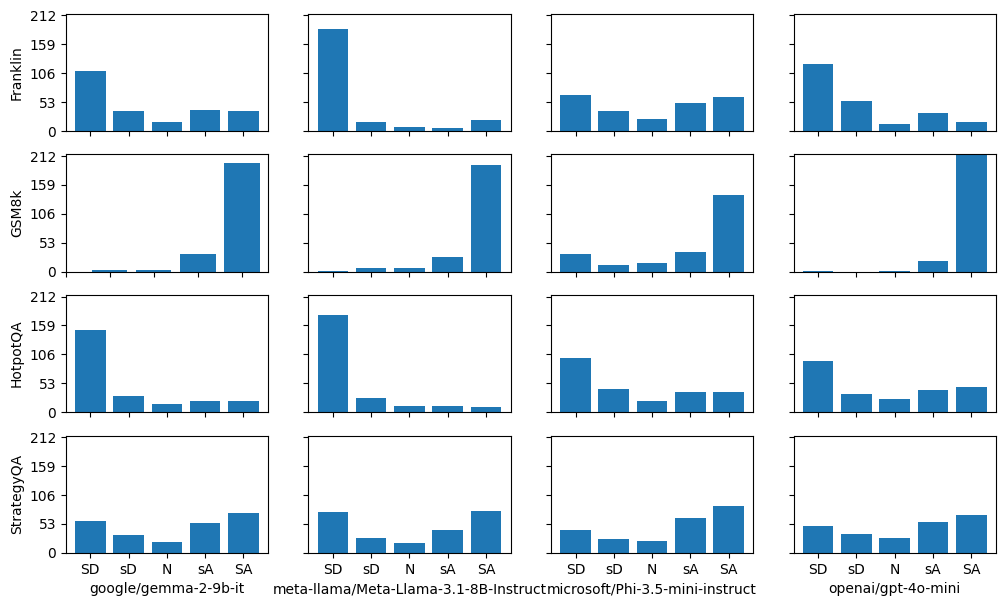

In [846]:
analysis.plot_histograms(Q2)

In [847]:
analysis.counts_gt_n(Q1, 3)

,dataset,model,counts_greater_than_3
0,Franklin,google/gemma-2-9b-it,0.19
1,Franklin,meta-llama/Meta-Llama-3.1-8B-Instruct,0.22
2,Franklin,microsoft/Phi-3.5-mini-instruct,0.30
3,Franklin,openai/gpt-4o-mini,0.46
4,GSM8k,google/gemma-2-9b-it,0.94
5,GSM8k,meta-llama/Meta-Llama-3.1-8B-Instruct,0.91
6,GSM8k,microsoft/Phi-3.5-mini-instruct,0.68
7,GSM8k,openai/gpt-4o-mini,0.98
8,HotpotQA,google/gemma-2-9b-it,0.70
9,HotpotQA,meta-llama/Meta-Llama-3.1-8B-Instruct,0.32


**When a plan is present vs not present, does satisfaction in response differ?**

In [848]:
# first turn each df into point scale 3
for (dataset, model), df in Q2.items():
    Q2[(dataset, model)] = df.map(analysis.i2i)
# use majority vote on 3 point scale
Q2 = analysis.majority_vote(Q2)
# get columns where all values are 3 (indicates plan present)
Q2_plan_positive = {}
for (dataset, model), df in Q2.items():
    plan_positive = df.apply(lambda x: (x == 3).all(), axis=0)
    # get cols from plan_positive where value is True
    plan_positive = plan_positive[plan_positive == True]
    Q2_plan_positive[(dataset, model)] = plan_positive.index
# get columns where all values are 1 (indicates plan not present)
Q2_plan_negative = {}
for (dataset, model), df in Q2.items():
    plan_negative = df.apply(lambda x: (x == 1).all(), axis=0)
    # get cols from plan_negative where value is True
    plan_negative = plan_negative[plan_negative == True]
    Q2_plan_negative[(dataset, model)] = plan_negative.index

# now get columns from Q3
sat_vs_plan = []
for (dataset, model), df in Q3.items():
    pos_cols = Q2_plan_positive[(dataset, model)]
    neg_cols = Q2_plan_negative[(dataset, model)]
    sat_vs_plan.append(
        {
            'dataset': dataset,
            'model': model,
            'positive_sat': df[pos_cols].mean().mean(),
            'negative_sat': df[neg_cols].mean().mean(),
        }
    )

sat_vs_plan = pd.DataFrame(sat_vs_plan).round(2)
sat_vs_plan

,dataset,model,positive_sat,negative_sat
0,Franklin,google/gemma-2-9b-it,3.23,2.08
1,Franklin,meta-llama/Meta-Llama-3.1-8B-Instruct,4.78,1.67
2,Franklin,microsoft/Phi-3.5-mini-instruct,3.38,2.06
3,Franklin,openai/gpt-4o-mini,3.98,2.73
4,GSM8k,google/gemma-2-9b-it,4.66,NaN
5,GSM8k,meta-llama/Meta-Llama-3.1-8B-Instruct,4.52,NaN
6,GSM8k,microsoft/Phi-3.5-mini-instruct,3.96,1.34
7,GSM8k,openai/gpt-4o-mini,4.84,NaN
8,HotpotQA,google/gemma-2-9b-it,4.24,3.32
9,HotpotQA,meta-llama/Meta-Llama-3.1-8B-Instruct,4.50,1.95
